# LangGraph Handling LangChain Agent Intermediate_Steps 


In this notebook we will learn how to build a basic [agent executor](https://api.python.langchain.com/en/latest/agents/langchain.agents.agent.AgentExecutor.html) leveraging [langGraph](https://github.com/langchain-ai/langgraph).

We demonstrate how to handle the logic of the intermediate steps from the agent leveraging different provided tools within langGraph.

- We will be leveraging LLM ai-mixtral-8x7b-instruct 


- Wikipedia (the pip installable package) as one of the tools.

Then we will utilize with LangGraph to control and intervene intermediate steps as well as the outputs from the agent.


## Prerequisites 

To run this notebook, you need the following:

1. Installed necesary Python dependencies in [requirements.txt](https://github.com/NVIDIA/GenerativeAIExamples/blob/main/notebooks/requirements.txt) 




## Install additional Python packages 

Install the additional packages that required for this example, assuming that installed all the python packages from the [requirements.txt](https://github.com/NVIDIA/GenerativeAIExamples/blob/main/notebooks/requirements.txt) file.

In [ ]:
# !pip install --upgrade pip
# !pip install wikipedia==1.4.0
# !pip install langchain-community==0.2.2
# !pip install langchain==0.2.2
# !pip install langgraph==0.0.62
# !pip install faiss-gpu==1.7.2

In [10]:
#! pip install wikipedia
# ! pip install -U langchain-openai
# !sudo apt-get install python3-dev graphviz libgraphviz-dev pkg-config
# ! pip install pygraphviz
#!pip show langchain #Version: 0.1.20

#!pip show langchain-openai

In [1]:
import os
from langchain.tools import BaseTool
from langchain.chat_models import ChatOpenAI
# from langchain_openai import ChatOpenAI
from IPython.display import Image
from textwrap import dedent

In [9]:
# from langchain.tools.python.tool import PythonREPLTool
# from langchain.python import PythonREPL

Optionally, we can set API key for [LangSmith tracing](https://smith.langchain.com/), which will give us best-in-class observability.

# Step 1 - Initialize the LLM and embedding models

The following code sets ai-mixtral-8x7b-instruct as the main LLM and ai-embed-qa-4 as the embedding model.

In [2]:
llm = ChatOpenAI(
    model = "mistral-instruct-7b",
    base_url = "http://localhost:5000/v1", 
    temperature=0.99,
    api_key='NA',
    verbose=1,
    streaming=1,
    max_tokens=2048,        
    model_kwargs={
        "top_p": 0.9, 
        #"top_k" : 1,          
        #"context_length":4096,
        #"threads": int(os.cpu_count()/2),
        #"repetition_penalty":1.1,
    }
)

/home/fredsena/.pyenv/versions/3.11.9/envs/jupython311_env/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(


In [4]:
from langchain.tools import BaseTool

class FileReaderTool(BaseTool):
    name = "FileReaderTool"
    description = "Useful for when you need to Read the contents of the specified file and returns it as a string."

    def _run(self, filePath):
        try:
            with open(filePath, 'r') as file:
                contents = file.read()
            return contents
        except Exception as e:
            return f"An error occurred while reading the file: {str(e)}"

    def _arun(self, query: str):
        raise NotImplementedError("This tool does not support async")
fileReaderTool=FileReaderTool()

In [21]:
file = '/home/fredsena/FredCodes/GIT/EMAILS/DoYouHaveStumblingBlocksPitfalls.txt'

fileReaderTool.run(file)

"Sender: Evan Bachtold <evanbachtold@gmail.com>\nRecipient: undisclosed-recipients:;\nSubject: Do you have any stumbling blocks or pitfalls?\nDate: Sat, 18 May 2024 11:28:07 +0100\n\nIf so, you are like me and look forward to our Men's zoom tomorrow\nmorning.  Only 2 left until summer break.  We will look at Romans 14.  Hope\nyou are able to join 8:00 AM!\n\nhttps://us02web.zoom.us/j/6054416511?omn=81732385349\n\n☕📖🙏\n\nEvan\n"

In [5]:
from langchain.tools import BaseTool

class FolderReadTool(BaseTool):
    name = "FolderReadTool"
    description = "Useful for when you need to Read a folder and return the list of files."

    def _run(self, folderPath):
        try:
            # Check if the folder exists
            if not os.path.isdir(folderPath):
                return f"Error: The folder '{folderPath}' does not exist."

            # Get the list of files in the folder
            files = os.listdir(folderPath)
            # return "\n".join(files) if files else "The folder is empty."
            return files if files else []
        except Exception as e:
            return f"An error occurred: {str(e)}"

    def _arun(self, query: str):
        raise NotImplementedError("This tool does not support async")
folderReadTool=FolderReadTool()

In [6]:
folder = "/home/fredsena/FredCodes/GIT/EMAILS/"

folderReadTool.run(folder)

['DoYouHaveStumblingBlocksPitfalls.txt', 'YouAppearedIn4Searches.txt']

## Step 2 - Construct wikipedia as the second tool


In [7]:
from langchain_community.tools.wikipedia.tool import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

wikipedia = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())

## Step 3 - Give your tools a good name and populate the description 

In [8]:
from langchain.tools import Tool

## Make sure you give it a proper name and a good description on how to use the tools
wiki_tool = Tool.from_function(
    func=wikipedia.run,
    name="Wiki",
    description="useful for when you need to search certain topic on Wikipedia, aka wiki")
fileReader_tool=Tool.from_function(
    func=fileReaderTool.invoke,
    name="FileReaderTool",
    description="Useful for when you need to Read the contents of the specified file and returns it as a string")
folderRead_tool=Tool.from_function(
    func=folderReadTool.invoke,
    name="FolderReadTool",
    description="Useful for when you need to Read a folder and return the list of files")

tools = [wiki_tool, folderRead_tool, fileReader_tool]

## Step 4 - Wrap tools into ToolExecutor 

We will use these ToolExecutor to invoke tool in LangGraph nodes later on.

In [9]:
from langchain_core.agents import AgentFinish
from langgraph.prebuilt.tool_executor import ToolExecutor

# This a helper class we have that is useful for running tools
# It takes in an agent action and calls that tool and returns the result
tool_executor = ToolExecutor(tools)


## Step 5 - Create the prompt template and conversation memory

The following code creates a memory buffer for storing queries and responses.
It also demonstrates how to write a prompt template for a Mistral mode that uses conversation memory and the Wiki and retriever tools.

In [10]:
# import os
# from langchain.agents import AgentExecutor
# from langchain.agents import initialize_agent
# from langchain.prompts import MessagesPlaceholder
# from langchain.memory import ConversationBufferMemory
# from langchain.agents import AgentType, Agent, ConversationalAgent
# from langchain_core.prompts import ChatPromptTemplate, PromptTemplate

# ## set up memory
# memory = ConversationBufferMemory(memory_key="chat_history", input_key='input', output_key="output")


# prompt_template = """
# ### [INST]

# Assistant is a large language model trained by Mistral.

# Assistant is designed to be able to assist with a wide range of tasks, from answering simple questions to providing in-depth explanations and discussions on a wide range of topics. As a language model, Assistant is able to generate human-like text based on the input it receives, allowing it to engage in natural-sounding conversations and provide responses that are coherent and relevant to the topic at hand.

# Assistant is constantly learning and improving, and its capabilities are constantly evolving. It is able to process and understand large amounts of text, and can use this knowledge to provide accurate and informative responses to a wide range of questions. Additionally, Assistant is able to generate its own text based on the input it receives, allowing it to engage in discussions and provide explanations and descriptions on a wide range of topics.

# Overall, Assistant is a powerful tool that can help with a wide range of tasks and provide valuable insights and information on a wide range of topics. Whether you need help with a specific question or just want to have a conversation about a particular topic, Assistant is here to assist.

# Context:
# ------

# Assistant has access to the following tools:

# {tools}

# To use a tool, please use the following format:

# '''
# Thought: Do I need to use a tool? Yes
# Action: the action to take, should be one of [{tool_names}]
# Action Input: the input to the action
# Observation: the result of the action
# '''

# When you have a response to say to the Human, or if you do not need to use a tool, you MUST use the format:

# '''
# Thought: Do I need to use a tool? No
# Final Answer: [your response here]
# '''

# Begin!

# Previous conversation history:
# {chat_history}

# New input: {input}

# Current Scratchpad:
# {agent_scratchpad}

# [/INST]
#  """

# # Create prompt from prompt template
# prompt = PromptTemplate(
#     input_variables=['agent_scratchpad', 'chat_history', 'input', 'tool_names', 'tools'],
#     template=prompt_template,
# )

# prompt = prompt.partial(
#     tools=[t.name for t in tools],
#     tool_names=", ".join([t.name for t in tools]),
# )
# print("prompt ---> \n", prompt)


In [12]:
import os
from langchain.agents import AgentExecutor
from langchain.agents import initialize_agent
from langchain.prompts import MessagesPlaceholder
from langchain.memory import ConversationBufferMemory
from langchain.agents import AgentType, Agent, ConversationalAgent
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate

## set up memory
memory = ConversationBufferMemory(memory_key="chat_history", input_key='input', output_key="output")


prompt_template = """
### [INST]

Assistant is a large language model trained by Mistral.

Assistant is designed to be able to assist with a wide range of tasks, from answering simple questions to providing in-depth explanations and discussions on a wide range of topics. As a language model, Assistant is able to generate human-like text based on the input it receives, allowing it to engage in natural-sounding conversations and provide responses that are coherent and relevant to the topic at hand.

Assistant is constantly learning and improving, and its capabilities are constantly evolving. It is able to process and understand large amounts of text, and can use this knowledge to provide accurate and informative responses to a wide range of questions. Additionally, Assistant is able to generate its own text based on the input it receives, allowing it to engage in discussions and provide explanations and descriptions on a wide range of topics.

Overall, Assistant is a powerful tool that can help with a wide range of tasks and provide valuable insights and information on a wide range of topics. Whether you need help with a specific question or just want to have a conversation about a particular topic, Assistant is here to assist.

Context:
------

Assistant has access to the following tools:

{tools}

To use a tool, please use the following format:

'''
Thought: Do I need to use a tool? Yes
Action: the action to take, should be one of [{tool_names}]
Action Input: the input to the action
Observation: the result of the action
'''

When you have a response to say to the Human, or if you do not need to use a tool, you MUST use the format:

'''
Thought: Do I need to use a tool? No
Final Answer: [your response here]
'''

Begin!

New input: {input}

Current Scratchpad:
{agent_scratchpad}

[/INST]
 """

# Create prompt from prompt template
prompt = PromptTemplate(
    input_variables=['agent_scratchpad', 'input', 'tool_names', 'tools'],
    template=prompt_template,
)

prompt = prompt.partial(
    tools=[t.name for t in tools],
    tool_names=", ".join([t.name for t in tools]),
)
#print("prompt ---> \n", prompt)


## Step 6 - Establish agent executor using LangChain  

In [13]:
from typing import Any, Optional, Sequence

from langchain_core._api import deprecated
from langchain_core.callbacks import BaseCallbackManager
from langchain_core.language_models import BaseLanguageModel
from langchain_core.tools import BaseTool

from langchain.agents.agent import AgentExecutor
from langchain.agents.agent_types import AgentType
from langchain.agents.loading import AGENT_TO_CLASS, load_agent

agent_cls = AGENT_TO_CLASS[AgentType.CONVERSATIONAL_REACT_DESCRIPTION]
agent_kwargs = {}
agent_obj = agent_cls.from_llm_and_tools(
    llm, tools, callback_manager=None, **agent_kwargs)

agent_execute=AgentExecutor.from_agent_and_tools(
        agent=agent_obj,
        tools=tools,
        callback_manager=None,
        handle_parsing_errors=True,
        verbose=True,
        output_key = "output",
        max_iterations=3,
        return_intermediate_steps=True,
        early_stopping_method="generate", # or use **force**
        memory=ConversationBufferMemory(memory_key="chat_history", input_key='input', output_key="output")
)

## Step 7 - Define the graph state

We now define the graph state. The state for the traditional LangChain agent has a few attributes:

1. `input`: This is the input string representing the main ask from the user, passed in as input.
2. `chat_history`: This is any previous conversation messages, also passed in as input.
3. `intermediate_steps`: This is list of actions and corresponding observations that the agent takes over time. This is updated each iteration of the agent.
4. `agent_outcome`: This is the response from the agent, either an AgentAction or AgentFinish. The AgentExecutor should finish when this is an AgentFinish, otherwise it should call the requested tools.


In [14]:
from typing import TypedDict, Annotated, List, Union
from langchain_core.agents import AgentAction, AgentFinish
from langchain_core.messages import BaseMessage
import operator


class AgentState(TypedDict):
    # The input string
    input: str
    # The list of previous messages in the conversation
    #chat_history: list[BaseMessage]
    # The outcome of a given call to the agent
    # Needs `None` as a valid type, since this is what this will start as
    agent_outcome: Union[AgentAction, AgentFinish, None]
    # List of actions and corresponding observations
    # Here we annotate this with `operator.add` to indicate that operations to
    # this state should be ADDED to the existing values (not overwrite it)
    intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]


## Step 8 - Define the nodes

We now need to define a few different nodes in our graph.
In LangGraph, a node can be either a function or a [runnable](https://python.langchain.com/docs/expression_language/).
There are two main nodes we need for this:

1. The agent (`run_agent`): responsible for deciding what (if any) actions to take.
2. A function to invoke tools (`execute_tools`): if the agent decides to take an action, this node will then execute that action.

We will also need to define some edges.
Some of these edges may be conditional.
The reason they are conditional is that based on the output of a node, one of several paths may be taken.
The path that is taken is not known until that node is run (the LLM decides).

1. Conditional Edge (`should_continue`): after the agent is called, we should either:
   - If the agent said to take an action, then the function to invoke tools is called.
   - If the agent said that it was finished, then it finishes.
   
2. Normal Edge: after the tools are invoked, it should always go back to the agent to decide what to do next.

Let's define the nodes, as well as a function to decide how what conditional edge to take.

In [15]:
# Define the agent
from langchain_core.agents import AgentActionMessageLog

def run_agent(data):
    inputs = data.copy()
    text = inputs['input']
    agent_outcome = agent_execute.invoke({"input":text})
    return {"agent_outcome": agent_outcome}

# Define the function to execute tools
def execute_tools(data):
    # Get the most recent agent_outcome - this is the key added in the `agent` above
    agent_output = data["agent_outcome"]
    if len(agent_output['intermediate_steps'])>=1 :
        agent_action = agent_output['intermediate_steps'][0][0]
        output = tool_executor.invoke(agent_action)
        return {"intermediate_steps": [(agent_action, str(output))]}
    else:
        return {"intermediate_steps":[]}

# Define logic that is used to determine which conditional edge to go down
def should_continue(data):
    # If the agent outcome is an AgentFinish, then we return `exit` string
    # This will be used when setting up the graph to define the flow
    if data["agent_outcome"]["output"] is not None:
        print(" **AgentFinish** " )
        return "end"
    # Otherwise, an AgentAction is returned
    # Here we return `continue` string
    # This will be used when setting up the graph to define the flow
    else:
        print(" **continue** " )
        return "continue"


## Step 9 - Connect the nodes with edges to form the graph, let's call it **app**

In [16]:
from langgraph.graph import END, StateGraph

# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", run_agent)
workflow.add_node("action", execute_tools)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "action",
        # Otherwise we finish.
        "end": END,
    },
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("action", "agent")

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile()


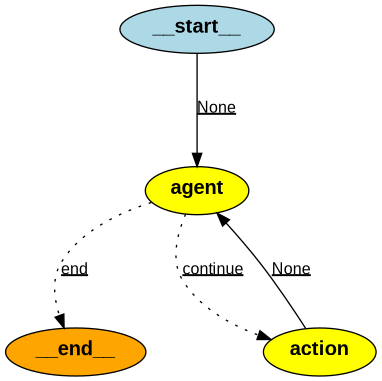

In [32]:
Image(app.get_graph().draw_png())

## Step 10 - Time to test it out

Let's start by seeing if we can trigger the retriever tool (tool name: AboutSweden).


Then, we will try to call the Wikipedia tool (tool name : Wiki).

In [21]:
info = dedent("""\
                List all files from the folder: /home/fredsena/FredCodes/GIT/EMAILS/ then
                For each email from the folder: /home/fredsena/FredCodes/GIT/EMAILS/, pull and analyze it.
                Consider any txt file as an email. 
                If no links are found in an email, proceed to the next email. 
                If the email file is a None value, ignore it and proceed to the next one.
                understand the context, key points of the conversation. 
                then start reading the email file, read its content, summarize it and then proceed to the next one and so on.
                IMPORTANT: ALWAYS USE The FolderReaderTool tool and The FileReaderTool tool              
                """)

#inputs = {"input": "What is Brazil's population in 2024?"}
inputs = {"input": info, "filePath": '/home/fredsena/FredCodes/GIT/EMAILS/'}

#print(inputs)

In [24]:
outputs = app.invoke(inputs)



> Entering new AgentExecutor chain...
Thought: Do I need to use a tool? Yes
Action: FolderReadTool
Action Input: /home/fredsena/FredCodes/GIT/EMAILS/
Observation: ['DoYouHaveStumblingBlocksPitfalls.txt', 'YouAppearedIn4Searches.txt']
Thought:Do I need to use a tool for the next task? Yes
Action: FolderReadTool
Action Input: /home/fredsena/FredCodes/GIT/EMAILS/
Observation: ['DoYouHaveStumblingBlocksPitfalls.txt', 'YouAppearedIn4Searches.txt']
Thought:It seems that the FolderReadTool has already been used, and its output has been observed. Therefore, there is no need to repeat the action. The observation from the previous thought contains a list of all the files in the specified folder. I will proceed with analyzing the emails based on the existing information.

First, I will analyze the email named "DoYouHaveStumblingBlocksPitfalls.txt":

Summary: In this email, Evan Bachtold invites the recipients to a Men's Zoom meeting where they will discuss Romans 14. The meeting is scheduled fo

In [ ]:
## let's see if we can trigger our Wikipedia tool named : Wiki

inputs = {"input": "Find me Taylor Swift information on wiki?"}
outputs=app.invoke(inputs)